In [1]:
%matplotlib inline

import glob
import os
import json

import gspread
from IPython.core.display import HTML
import numpy as np
from oauth2client.client import SignedJwtAssertionCredentials
import pandas as pd
import pybedtools
import seaborn as sns

from gscripts.general import region_helpers
from gscripts.general import dataviz
import matplotlib as mpl

img_dir ="/home/gpratt/Dropbox/encode_integration/for_eric/idr_qc/"

peaks_dir = "/home/elvannostrand/data/clip/CLIPseq_analysis/ALLCLIP_v12_20160112/"

In [2]:
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [3]:
json_key = json.load(open("../public clip-588adbc137f3.json"))
scope = ['https://spreadsheets.google.com/feeds']

credentials = SignedJwtAssertionCredentials(json_key['client_email'], json_key['private_key'], scope)
gc = gspread.authorize(credentials)

sht1 = gc.open_by_url("https://docs.google.com/spreadsheets/d/1ZU2mQh54jentqvhR_oMnviLGWR8Nw_x338gULzKjNDI/edit#gid=0")
ws = sht1.worksheet("Sheet1")
list_of_lists = ws.get_all_values()
manifest = pd.DataFrame(list_of_lists[1:], columns=list_of_lists[0])
manifest['qc_id'] = manifest.apply(lambda x: "{}_{}".format(x.ENCODE_ID, x.RBP), axis=1)
manifest.is_encode = manifest.is_encode == "TRUE"
manifest['exp_id'] = manifest.ENCODE_ID.apply(lambda x: x.split("_")[0]).astype(str)

In [4]:
def fix_score(interval):
    interval.score = str(pow(2, float(interval.score)))
    return interval

In [5]:
class ArrayJob():
    def __init__(self):
        self._epilogue = "eval ${cmd[$PBS_ARRAYID]}"

    def _prologue(self, name, count, run_dir, ppn=1, walltime=8):
        return """#!/bin/bash
#PBS -N {0}
#PBS -l nodes=1:ppn={3}
#PBS -o {0}.out
#PBS -e {0}.err
#PBS -V
#PBS -q home-yeo
#PBS -W group_list=yeo-group
#PBS -t 1-{1}
#PBS -l walltime={4}:00:00
cd {2}
echo "hello, starting"

""".format(os.path.basename(name), count, run_dir, ppn, walltime)

        
    def make_script(self, commands, script_name, run_dir, ppn=1, walltime=8):
        total = 0 
        result = []
        num_out = 0
        for cmd in commands:
            total += 1
            result.append('cmd[{}]="{}"'.format(total, cmd))
            if total >= 500:
                with open("{}_{}.sh".format(script_name, num_out), 'w') as out_file:
                    out_file.write(self._prologue("{}_{}".format(script_name, num_out), total, run_dir, ppn, walltime ))
                    for line in result:
                        out_file.write(line + "\n\n")
                    out_file.write(self._epilogue + "\n")
                total = 0 
                num_out += 1
                result = []

        with open("{}_{}.sh".format(script_name, num_out), 'w') as out_file:
            out_file.write(self._prologue("{}_{}".format(script_name, num_out), total, run_dir, ppn, walltime))
            for line in result:
                out_file.write(line + "\n\n")
            out_file.write(self._epilogue + "\n")
            
job_maker = ArrayJob()


#Split bams and call peaks for self consistancy

In [7]:
merged_data = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/ALLCLIP_v12_20160112/encode_v12_filelist.allencode_20160314.txt")
merged_data.CLIP_rep1 = merged_data.CLIP_rep1.apply(lambda x: x.replace("/projects/ps-yeolab2/encode/analysis/encode_v12", "/home/gpratt/projects/encode/analysis/softlinked_bams"))
merged_data.CLIP_rep2 = merged_data.CLIP_rep2.apply(lambda x: x.replace("/projects/ps-yeolab2/encode/analysis/encode_v12", "/home/gpratt/projects/encode/analysis/softlinked_bams"))
merged_data.CLIP_rep1 = merged_data.CLIP_rep1.apply(lambda x: x.replace("/projects/ps-yeolab/encode/analysis/encode_v13", "/home/gpratt/projects/encode/analysis/softlinked_bams"))
merged_data.CLIP_rep2 = merged_data.CLIP_rep2.apply(lambda x: x.replace("/projects/ps-yeolab/encode/analysis/encode_v13", "/home/gpratt/projects/encode/analysis/softlinked_bams"))

In [8]:
idr_cmds = []
for name, row in merged_data.iterrows():
    idr_cmds.append("python ~/gscripts/gscripts/clipseq/perform_idr.py --bam {}  --premRNA --species hg19 --out baz --genome /projects/ps-yeolab/genomes/hg19/hg19.chrom.sizes".format(row.CLIP_rep1))
    idr_cmds.append("python ~/gscripts/gscripts/clipseq/perform_idr.py --bam {}  --premRNA --species hg19 --out baz --genome /projects/ps-yeolab/genomes/hg19/hg19.chrom.sizes".format(row.CLIP_rep2))  

In [9]:
job_maker.make_script(idr_cmds, 
                      "/home/gpratt/projects/encode/scripts/encode_self_consistancy", 
                      "/home/gpratt/projects/encode/analysis/enhancer_rnas",
                     walltime=48)

#Split bams and call peaks for pesuodreplicates 

In [10]:
idr_cmds = []

for name, row in merged_data.iterrows():
    idr_cmds.append("python ~/gscripts/gscripts/clipseq/perform_idr.py --bam {} --rep2 {} --merged_file_name {} --premRNA --species hg19 --out {} --genome /projects/ps-yeolab/genomes/hg19/hg19.chrom.sizes".format(row.CLIP_rep1, row.CLIP_rep2, str(row.uID) + "_", 'baz'))  

In [11]:
job_maker.make_script(idr_cmds, 
                      "/home/gpratt/projects/encode/scripts/encode_merged_pesudoreplicate", 
                      "/home/gpratt/projects/encode/analysis/enhancer_rnas",
                     walltime=48)

#Input Normalize All the peak files I just made

In [12]:
run_dir = "/home/gpratt/projects/encode/analysis/idr_errors/"

with open(os.path.join(run_dir, "manifest.txt"), 'w') as manifest:
    manifest.write("\t".join(['uID', 'RBP', 'Cell line', 'CLIP_rep1', 'CLIP_rep2', 'INPUT']) + "\n")
    for name, row in merged_data.iterrows():
        manifest.write("\t".join([str(row.uID) + "_rep1", row.RBP, row['Cell line'], os.path.join(run_dir, os.path.basename(row.CLIP_rep1) + "00.sorted.bam"), os.path.join(run_dir, os.path.basename(row.CLIP_rep1) + "01.sorted.bam"), row.INPUT]) + "\n")
        manifest.write("\t".join([str(row.uID) + "_rep2", row.RBP, row['Cell line'], os.path.join(run_dir, os.path.basename(row.CLIP_rep2) + "00.sorted.bam"), os.path.join(run_dir, os.path.basename(row.CLIP_rep2) + "01.sorted.bam"), row.INPUT]) + "\n")
        manifest.write("\t".join([str(row.uID) + "_combined", row.RBP, row['Cell line'], os.path.join(run_dir, str(row.uID) + "_00.sorted.bam"), os.path.join(run_dir, str(row.uID) + "_01.sorted.bam"), row.INPUT]) + "\n")

#Copy stuff into a new dir, I do this because sometimes the manifest deletes things

cp /home/gpratt/projects/encode/analysis/enhancer_rnas/* /home/gpratt/projects/encode/analysis/idr_errors

cp /home/gpratt/projects/encode/analysis/softlinked_bams/* /home/gpratt/projects/encode/analysis/idr_errors

cp /home/gpratt/projects/encode/analysis/idr_errors 

#This executes the manifest
/home/gpratt/projects/encode/analysis/idr_errors/run.sh 

#Run IDR on input normalized the pesudoreplicate and self consistant peaks

In [14]:
peaks_dir = "/home/gpratt/projects/encode/analysis/idr_input_norm/"
data = glob.glob(os.path.join(peaks_dir, "*.bed.compressed.bed"))

result = {}
for item in data:
    key = os.path.basename(item).split(".")[0].split("_")
    result[tuple(key)] = item
    
result = pd.Series(result).dropna()
result.index.names = ['uid', 'rep', 'split_id']

idr_cmds = []
for name, row in result.groupby(level=["uid", 'rep']):
    try:
        rep1, rep2 = row.values
    except ValueError:
        continue
        
    rep1 = os.path.join(peaks_dir, rep1)
    rep2 = os.path.join(peaks_dir, rep2)
    rep1 = os.path.join(os.getcwd(), pybedtools.BedTool(rep1).each(fix_score).saveas(os.path.basename(rep1)).fn)
    rep2 = os.path.join(os.getcwd(), pybedtools.BedTool(rep2).each(fix_score).saveas(os.path.basename(rep2)).fn)

    output = "_".join(os.path.basename(rep1).split("_")[:2]) + ".txt"
    idr_cmds.append("idr --samples {} {} --input-file-type bed --rank 5 --peak-merge-method max --plot -o {}".format(rep1, rep2, output))

KeyboardInterrupt: 

In [ ]:
job_maker.make_script(idr_cmds, 
                      "/home/gpratt/projects/encode/scripts/encode_idr_score", 
                      "/home/gpratt/projects/encode/analysis/idr_analysis_score/",
                     walltime=4)

#Run IDR on all input normalized peaks

In [ ]:
df = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/ALLCLIP_v12_20160112/encode_v12_filelist.allencode_20160314.txt")

def eplouge(name,count):
    return """#!/bin/bash
#PBS -N {0}
#PBS -l nodes=1:ppn=1
#PBS -o {0}.out
#PBS -e {0}.err
#PBS -V
#PBS -q home-yeo
#PBS -W group_list=yeo-group
#PBS -t 1-{1}
#PBS -l walltime=8:00:00
source activate py3
cd /home/gpratt/projects/encode/analysis/idr_analysis_score/
echo "hello, starting"
""".format(name, count)

prolouge = "eval ${cmd[$PBS_ARRAYID]}"

def eplouge_py3(name,count, run_dir="/home/gpratt/projects/encode/analysis/idr_analysis_p_value/"):
    return """#!/bin/bash
#PBS -N {0}
#PBS -l nodes=1:ppn=1
#PBS -o {0}.out
#PBS -e {0}.err
#PBS -V
#PBS -q home-yeo
#PBS -W group_list=yeo-group
#PBS -t 1-{1}
#PBS -l walltime=2:00:00
source activate py3
cd {2}
echo "hello, starting"
""".format(name, count, run_dir)

prolouge = "eval ${cmd[$PBS_ARRAYID]}"

In [15]:
idr_cmds = [] 
for name, row in df.iterrows():
    rep1 = os.path.join(peaks_dir, (row['CLIP_rep1']))
    rep2 = os.path.join(peaks_dir, (row['CLIP_rep2']))
    
    output = os.path.basename(rep1).split("_")[0] + ".txt"

    idr_cmds.append("idr --samples {} {} --input-file-type bed --rank 4 --peak-merge-method max --plot -o {}".format(rep1, rep2, output))

In [16]:
total = 0 
result = []
for cmd in idr_cmds:
    total += 1
    result.append('cmd[{}]="{}"'.format(total, cmd))
    
with open(os.path.join("/home/gpratt/projects/encode/scripts", "encode_idr_p_value.sh"), 'w') as out_file:
    out_file.write(eplouge("encode_idr", total))
    for line in result:
        out_file.write(line + "\n\n")
    out_file.write(prolouge + "\n")

#Run IDR and rank by col 5

In [17]:
idr_cmds = [] 
for name, row in df.iterrows():
    rep1 = os.path.join(peaks_dir, (row['CLIP_rep1']))
    rep2 = os.path.join(peaks_dir, (row['CLIP_rep2']))
    try:
        rep1 = os.path.join(os.getcwd(), pybedtools.BedTool(rep1).each(fix_score).saveas(os.path.basename(rep1)).fn)
        rep2 = os.path.join(os.getcwd(), pybedtools.BedTool(rep2).each(fix_score).saveas(os.path.basename(rep2)).fn)
#         rep1 = os.path.join(os.getcwd(), os.path.basename(rep1))
#         rep2 = os.path.join(os.getcwd(), os.path.basename(rep2))

    except ValueError as e:
        print e
        pass
    output = os.path.basename(rep1).split("_")[0] + ".txt"

    idr_cmds.append("idr --samples {} {} --input-file-type bed --rank 5 --peak-merge-method max --plot -o {}".format(rep1, rep2, output))

KeyboardInterrupt: 

In [21]:
total = 0 
result = []
for cmd in idr_cmds:
    total += 1
    result.append('cmd[{}]="{}"'.format(total, cmd))
    
with open(os.path.join("/home/gpratt/projects/encode/scripts", "encode_idr_score.sh"), 'w') as out_file:
    out_file.write(eplouge("encode_idr", total))
    for line in result:
        out_file.write(line + "\n\n")
    out_file.write(prolouge + "\n")

In [15]:
def filter_data(interval):
    #col4 is -log10 p-val
    #col5 is -log2 fold enrichment
    return (float(interval[4]) > 3) and (float(interval[3]) > 5)

In [23]:
result = {}
for name, row in df.iterrows():
    encode_id = row['uID_01.basedon_uID_01.peaks.l2inputnormnew.bed.compressed.bed'].split("_")[0]
    try:
        rep1 = pybedtools.BedTool(os.path.join(peaks_dir, (row['uID_01.basedon_uID_01.peaks.l2inputnormnew.bed.compressed.bed'])))
        rep2 = pybedtools.BedTool(os.path.join(peaks_dir, (row['uID_02.basedon_uID_02.peaks.l2inputnormnew.bed.compressed.bed'])))
        idr_peaks = pybedtools.BedTool("/home/gpratt/projects/encode/analysis/idr_analysis_score/{}.txt".format(encode_id))
    except ValueError as e:
        print e
        continue
    rep1_enriched = rep1.filter(filter_data).saveas()
    rep2_enriched = rep2.filter(filter_data).saveas()
    idr_peaks_filtered = idr_peaks.filter(lambda x: float(x.score) > 540).saveas()
    
    overlapping_r1_r2 = rep1.intersect(rep2, s=True, u=True)
    overlapping_r1_r2_enriched = overlapping_r1_r2.filter(filter_data).saveas()
    
    result[encode_id] = {"rep1_enriched_peaks": len(rep1_enriched),
                         "idr_peaks": len(idr_peaks),
                         "rep1_rep2_overlap": len(overlapping_r1_r2),
                         "rep1_rep2_overlap_enriched": len(overlapping_r1_r2_enriched),
                         "rep1_enriched_with_idr": len(rep1_enriched.intersect(idr_peaks_filtered, u=True)),
                         "overlapping_enriched_with_idr": len(overlapping_r1_r2_enriched.intersect(idr_peaks_filtered, u=True)) 
                        }
    
result = pd.DataFrame(result).T

KeyError: 'uID_01.basedon_uID_01.peaks.l2inputnormnew.bed.compressed.bed'

In [24]:
result['rep1_enriched_fraction'] = result.overlapping_enriched_with_idr / result.rep1_enriched_peaks
result['overlapping_enriched_fraction'] = result.overlapping_enriched_with_idr / result.rep1_rep2_overlap_enriched

AttributeError: 'dict' object has no attribute 'overlapping_enriched_with_idr'

In [287]:
img_dir = "."
num_cols = 1
num_rows = 1

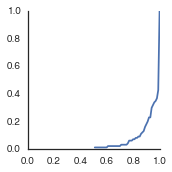

In [357]:
with dataviz.Figure(os.path.join(img_dir, "overlapping_enriched.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    dataviz.plot_cdf(result.overlapping_enriched_fraction, ax=ax)
    ax.set_xlim(0,1)
    sns.despine(ax=ax)

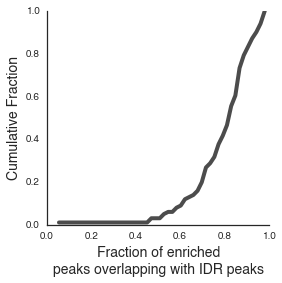

In [361]:
with dataviz.Figure(os.path.join(img_dir, "overlapping_enriched.svg"), figsize=(4 * num_cols,4*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    dataviz.plot_cdf(result.rep1_enriched_fraction, ax=ax, linewidth=4, alpha=.7, color='k')
    ax.set_xlim(0,1)
    sns.despine(ax=ax)
    ax.set_ylabel("Cumulative Fraction", fontsize=14)
    ax.set_xlabel("Fraction of enriched\npeaks overlapping with IDR peaks", fontsize=14)

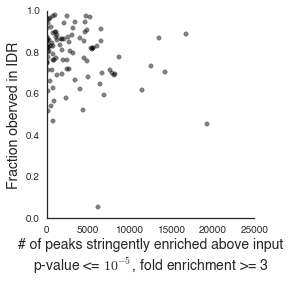

In [360]:
with dataviz.Figure(os.path.join(img_dir, "enriched_scatter.svg"), figsize=(4 * num_cols,4*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.scatter(result.rep1_enriched_peaks, result.rep1_enriched_fraction, color='k', alpha=.5)
    sns.despine(ax=ax)
    ax.set_ylim(0,1)
    ax.set_xlabel("# of peaks stringently enriched above input\np-value <= $10^{-5}$, fold enrichment >= 3", fontsize=14)
    ax.set_ylabel("Fraction oberved in IDR", fontsize=14)
    ax.set_xlim(0,)
    


#Calculate IDR stats

In [13]:
pesudoreplicate_merged = glob.glob("/home/gpratt/projects/encode/analysis/idr_analysis_score/*_combined.txt")
pesudoreplicate_merged = {os.path.basename(item).split("_")[0]: item for item in pesudoreplicate_merged}

rep1_merged = glob.glob("/home/gpratt/projects/encode/analysis/idr_analysis_score/*_rep1.txt")
rep1_merged = {os.path.basename(item).split("_")[0]: item for item in rep1_merged}

rep2_merged = glob.glob("/home/gpratt/projects/encode/analysis/idr_analysis_score/*_rep2.txt")
rep2_merged = {os.path.basename(item).split("_")[0]: item for item in rep2_merged}

replicate_merged = glob.glob("/home/gpratt/projects/encode/analysis/idr_analysis_score/*.txt")
replicate_merged = [item for item in replicate_merged if "_" not in os.path.basename(item)]
replicate_merged = {os.path.basename(item).split(".")[0]: item for item in replicate_merged}

In [14]:
idr_table = pd.DataFrame({"pesudoreplicate_merged": pesudoreplicate_merged,
          "rep1_merged": rep1_merged,
          "rep2_merged": rep2_merged,
          "replicate_merged": replicate_merged})

In [20]:
idr_table

,pesudoreplicate_merged,rep1_merged,rep2_merged,replicate_merged
202,NaN,/home/gpratt/projects/encode/analysis/idr_anal...,/home/gpratt/projects/encode/analysis/idr_anal...,NaN
203,/home/gpratt/projects/encode/analysis/idr_anal...,/home/gpratt/projects/encode/analysis/idr_anal...,/home/gpratt/projects/encode/analysis/idr_anal...,NaN
204,/home/gpratt/projects/encode/analysis/idr_anal...,/home/gpratt/projects/encode/analysis/idr_anal...,/home/gpratt/projects/encode/analysis/idr_anal...,NaN
205,/home/gpratt/projects/encode/analysis/idr_anal...,/home/gpratt/projects/encode/analysis/idr_anal...,/home/gpratt/projects/encode/analysis/idr_anal...,NaN
206,/home/gpratt/projects/encode/analysis/idr_anal...,/home/gpratt/projects/encode/analysis/idr_anal...,/home/gpratt/projects/encode/analysis/idr_anal...,NaN
209,/home/gpratt/projects/encode/analysis/idr_anal...,/home/gpratt/projects/encode/analysis/idr_anal...,/home/gpratt/projects/encode/analysis/idr_anal...,NaN
211,/home/gpratt/projects/encode/analysis/idr_anal...,/home/gpratt/projects/encode/analysis/idr_anal...,/home/gpratt/projects/encode/analysis/idr_anal...,NaN
213,NaN,/home/gpratt/projects/encode/analysis/idr_anal...,/home/gpratt/projects/encode/analysis/idr_anal...,NaN
214,/home/gpratt/projects/encode/analysis/idr_anal...,NaN,NaN,NaN
215,/home/gpratt/projects/encode/analysis/idr_anal...,/home/gpratt/projects/encode/analysis/idr_anal...,/home/gpratt/projects/encode/analysis/idr_anal...,NaN


In [15]:
def count_usable_reads(fn):
    try:
        bedtool = pybedtools.BedTool(fn)
        return len(bedtool.filter(lambda x: float(x.score) > 540))
    except Exception as e:
        print e
        return 0

In [16]:
idr_counts = idr_table.applymap(count_usable_reads)

float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float object is not an iterator
float ob

In [21]:
idr_counts

,pesudoreplicate_merged,rep1_merged,rep2_merged,replicate_merged,rescue_ratio,self_consistency_ratio,reproducibility_test,state
202,0,0,0,0,NaN,NaN,fail,In Progress
203,0,0,0,0,NaN,NaN,fail,In Progress
204,0,0,0,0,NaN,NaN,fail,In Progress
205,0,0,0,0,NaN,NaN,fail,In Progress
206,0,0,0,0,NaN,NaN,fail,In Progress
209,0,0,0,0,NaN,NaN,fail,In Progress
211,0,0,0,0,NaN,NaN,fail,In Progress
213,0,0,0,0,NaN,NaN,fail,In Progress
214,0,0,0,0,NaN,NaN,fail,In Progress
215,0,0,0,0,NaN,NaN,fail,In Progress


In [17]:
def rescue_ratio(row):
    try:
        return max(row.pesudoreplicate_merged, row.replicate_merged) / float(min(row.pesudoreplicate_merged, row.replicate_merged))
    except Exception as e:
        print e
        return np.nan
def self_consistency_ratio(row):
    try:

        return max(row.rep1_merged, row.rep2_merged ) / float(min(row.rep1_merged, row.rep2_merged))
    except Exception as e:
        print e
        return np.nan

def reproducibility_test(row):
    if row.rescue_ratio < 2 and row.self_consistency_ratio < 2:
        return "pass"
    elif row.rescue_ratio < 2 or row.self_consistency_ratio < 2:
        return "borderline"
    else:
        return "fail"
def state(row):
    if any(row.values == 0):
        return "In Progress"
    else:
        return "done"

In [18]:
idr_counts['rescue_ratio'] =  idr_counts.apply(rescue_ratio, axis=1)
idr_counts['self_consistency_ratio'] =  idr_counts.apply(self_consistency_ratio, axis=1)
idr_counts['reproducibility_test'] = idr_counts.apply(reproducibility_test, axis=1)
idr_counts['state'] = idr_counts.apply(state, axis=1)

#General Descriptive Stats for IDR

/home/gpratt/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


ZeroDivisionError: float division by zero

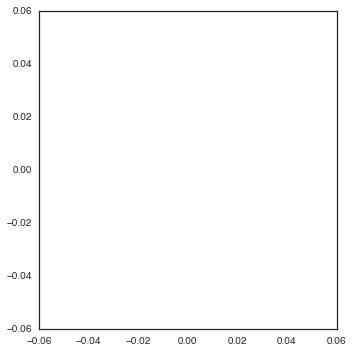

In [19]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "self_consistency_ratio.svg"), figsize=(5 * num_cols,5 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)

    sns.distplot(idr_counts.self_consistency_ratio.dropna(), kde=False, ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel("Count")
    ax.set_xlabel("Self Consistency Ratio")

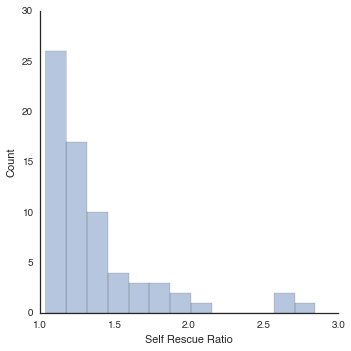

In [175]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "rescue_ratio.svg"), figsize=(5 * num_cols,5 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)

    sns.distplot(idr_counts.rescue_ratio.dropna(), kde=False, ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel("Count")
    ax.set_xlabel("Self Rescue Ratio")

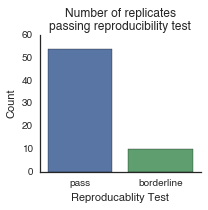

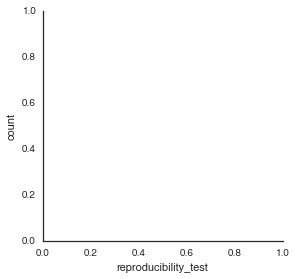

In [181]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "reproducibility_test.svg"), figsize=(3 * num_cols,3 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    sns.factorplot(x='reproducibility_test', kind='count', data=idr_counts[idr_counts.state != 'In Progress'], ax=ax)
    ax.set_ylabel("Count")
    ax.set_xlabel("Reproducablity Test")
    ax.set_title("Number of replicates\npassing reproducibility test")
    sns.despine(ax=ax)

In [74]:
!mkdir /home/gpratt/Dropbox/NatMethodsPaper/idr

In [75]:
idr_counts.to_csv("/home/gpratt/Dropbox/NatMethodsPaper/idr/idr_results.csv")

#Whats the actual overlap of PEAKS for the idr results vs the pesudo-replicates

In [211]:
def get_overlap_pesudo_and_real(row):
    pesudo_rep = pybedtools.BedTool(row.pesudoreplicate_merged).filter(lambda x: float(x.score) > 540)
    rep = pybedtools.BedTool(row.replicate_merged).filter(lambda x: float(x.score) > 540)
    return len(pesudo_rep.intersect(rep, u=True, s=True))

def get_overlap_real_and_pesudo(row):
    pesudo_rep = pybedtools.BedTool(row.pesudoreplicate_merged).filter(lambda x: float(x.score) > 540)
    rep = pybedtools.BedTool(row.replicate_merged).filter(lambda x: float(x.score) > 540)
    return len(rep.intersect(pesudo_rep, u=True, s=True))

def get_overlap_pesudo_rep1_and_rep2(row):
    pesudo_rep = pybedtools.BedTool(row.rep1_merged).filter(lambda x: float(x.score) > 540)
    rep = pybedtools.BedTool(row.rep2_merged).filter(lambda x: float(x.score) > 540)
    return len(rep.intersect(pesudo_rep, u=True, s=True))

def get_overlap_pesudo_rep2_and_rep1(row):
    pesudo_rep = pybedtools.BedTool(row.rep1_merged).filter(lambda x: float(x.score) > 540)
    rep = pybedtools.BedTool(row.rep2_merged).filter(lambda x: float(x.score) > 540)
    return len(pesudo_rep.intersect(rep, u=True, s=True))

In [206]:
pesudo_and_real_result = idr_table.dropna().apply(get_overlap_pesudo_and_real, axis=1)
real_and_pesudo_result = idr_table.dropna().apply(get_overlap_real_and_pesudo, axis=1)

In [212]:
pesudo_rep1_and_rep2_result = idr_table.dropna().apply(get_overlap_pesudo_rep1_and_rep2, axis=1)
pesudo_rep2_and_rep1_result = idr_table.dropna().apply(get_overlap_pesudo_rep2_and_rep1, axis=1)

In [217]:
idr_counts['overlapping_pesudo_and_real'] = pesudo_and_real_result
idr_counts['overlapping_real_and_pesudo'] = real_and_pesudo_result

idr_counts['overlapping_pesudo_rep1_and_rep2'] = pesudo_rep1_and_rep2_result
idr_counts['overlapping_pesudo_rep2_and_rep1'] = pesudo_rep2_and_rep1_result

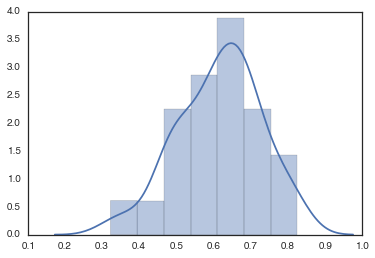

In [214]:
sns.distplot((idr_counts.overlapping_pesudo_and_real / idr_counts.pesudoreplicate_merged).dropna())

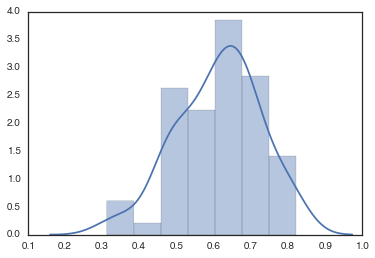

In [215]:
sns.distplot((idr_counts.overlapping_real_and_pesudo / idr_counts.pesudoreplicate_merged).dropna())

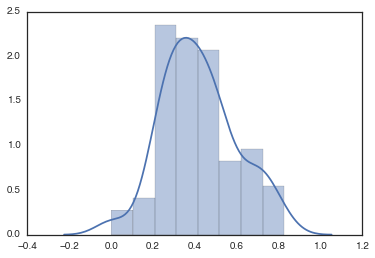

In [218]:
sns.distplot((idr_counts.overlapping_pesudo_rep1_and_rep2 / idr_counts.rep1_merged).dropna())

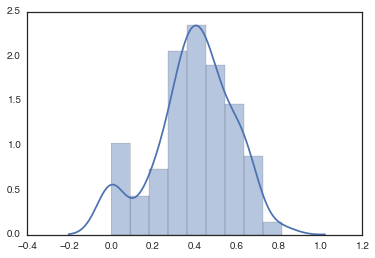

In [219]:
sns.distplot((idr_counts.overlapping_pesudo_rep2_and_rep1 / idr_counts.rep2_merged).dropna())

#What does SLBP look like

In [249]:
def add_order(bedtool):
    for x, interval in enumerate(bedtool):
        interval.append(x)
        yield interval

In [250]:
bedtool = pybedtools.BedTool("/home/gpratt/projects/encode/analysis/idr_analysis_score/262.txt").filter(lambda x: float(x.score) > 540).saveas()
bedtool = pybedtools.BedTool(add_order(bedtool)).saveas()

In [253]:
bedtool_sort_order = bedtool.to_dataframe(names=range(15))

In [255]:
genes = pybedtools.BedTool("/home/gpratt/clipper/clipper/data/regions/hg19_genes.bed")
gene_id_to_name = region_helpers.gene_id_to_name("/projects/ps-yeolab/genomes/hg19/gencode.v17.annotation.gtf.db")
gene_id_to_type = region_helpers.gene_id_to_type("/projects/ps-yeolab/genomes/hg19/gencode.v17.annotation.gtf.db")

name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

In [259]:
overlapping_genes = bedtool.intersect(genes, s=True, wo=True).saveas()
overlapping_genes_df = overlapping_genes.to_dataframe(names=range(22))
overlapping_genes_df['gene_name'] = overlapping_genes_df[18].apply(lambda x: gene_id_to_name[x])
overlapping_genes_df['is_histone'] = overlapping_genes_df.gene_name.apply(lambda x: "HIST" in x)

In [263]:
grouped_overlapping_df = overlapping_genes_df.groupby([0,1,2]).first()
grouped_overlapping_df = grouped_overlapping_df.sort_values(14)

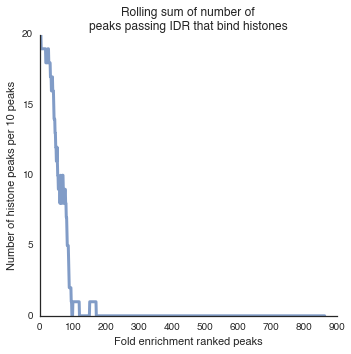

In [283]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "rolling_mean.svg"), figsize=(5 * num_cols,5 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.plot(pd.rolling_sum(grouped_overlapping_df.is_histone, window=20).dropna().values, linewidth=3, alpha=.7)
    ax.set_ylabel("Number of histone peaks per 10 peaks")
    ax.set_title("Rolling sum of number of\npeaks passing IDR that bind histones")
    ax.set_xlabel("Fold enrichment ranked peaks")
    sns.despine(ax=ax)
    